# Basics

In [1]:
# hide
import sys
sys.path.append("..")

In [2]:
# export
# default_exp normalize
import SimpleITK as sitk
from fastai.basics import *

## Scale and Normalize images

Especially for MRI the pixel values can vary between scanner types. However, the imagenet stats, as provided by fastai should probably not be used, as they are specfic for color images and not MRI images. The optimal solution would probably be to calculate the stats on the present dataset. 

Statistics of intensity values, pooled across the whole training dataset (raw, unscaled pixel values and pixel values scaled between 0 and 1)

| Statistic                            | ADC       | T2          | T1 map   |
|--------------------------------------|-----------|-------------|----------|
| Pooled Maximum of intensity values   | 3064.2500 | 1369.5652   | 4095     |
| Pooled Minimum of intensity values   | 0.        | 0.          | 0.       |
| Pooled Mean of intensity values      | 511.1060  | 259.1454    | 740.8268 |
| Pooled SD of intensity values        | 488.8707  | 190.2448    | 688.8238 |
| Scaled Maximum of intensity values   | 1.        | 1.          | 1.       |
| Scaled Minimum of intensity values   | 0.        | 0.          | 0.       |
| Scaled Mean of intensity values      | 0.1675    | 0.1918      | 0.1809   |
| Scaled SD of intensity values        | 0.1599    | 0.1409      | 0.1682   |


However, just scaling wiht one mean and std might not be the optimal solution (see the excelent [Kaggle kernel](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) form Jeremy Howard why). Although for MRI images it might be ok, as the pixel values are closer together.

### Histogram scaling

In [3]:
im1 = TensorDicom3D(im[10:20])

NameError: name 'TensorDicom3D' is not defined

In [ ]:
# export 
@patch
def freqhist_bins(t:(TensorDicom3D,Tensor), n_bins=100):
    '''
    A function to split the range of pixel values into groups, such that each group has around the same number of pixels. 
    taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
    '''
    imsd = t.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(t:(TensorDicom3D,Tensor), brks=None):
    '''
    Scales a tensor using `freqhist_bins` to values between 0 and 1
    taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
    '''
    if t.device.type=='cuda': return t.hist_scaled_pt(brks)
    if brks is None: brks = t.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = t.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    x = tensor(x).reshape(t.shape).clamp(0.,1.)
    return x # will loose meta data in process

@patch
def hist_scaled_pt(t:(TensorDicom3D,Tensor), brks=None):
    "same as fastai fucntion for PILDicom"
    # Pytorch-only version - switch to this if/when interp_1d can be optimized
    if brks is None: brks = t.freqhist_bins()
    brks = brks.to(t.device)
    ys = torch.linspace(0., 1., len(brks)).to(t.device)
    return t.flatten().interp_1d(brks, ys).reshape(t.shape).clamp(0.,1.)

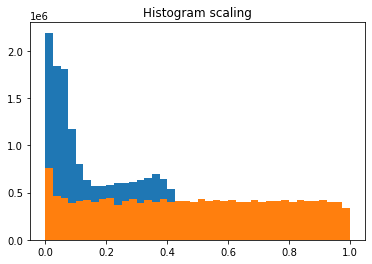

In [ ]:
# adaptie histogram scaling
plt.hist(im.flatten().numpy()/im.max().numpy(), bins = 40)
plt.hist(im.hist_scaled().flatten().numpy(), bins = 40)
plt.title("Histogram scaling") 
plt.show()

### Mean, Median and Max scaling

In [ ]:
#export
@patch
def normalize(t:TensorDicom3D, 
              norm_type = 'mean'):
    "normalizes a 3D Tensor, 0 voxels are not included for normalization"
    if norm_type == 'mean':
        mask = t.ne(0.)
        mean, sd = t[mask].mean(), t[mask].std()
        return (t - mean) / sd
    
    if norm_type == 'median':
        mask = t.ne(0.)
        if mask.view(-1).shape[0] >=2 **16: 
            # resize to large tensor for quantile
            # qunatile takes up to size 2**24, but than takes ~1sec 
            mask = F.interpolate(t[mask].view(-1).unsqueeze(0).unsqueeze(0), 2**16)
        median, iqr = mask.median(), mask.quantile(0.75)-mask.quantile(0.25)
        return (t-median)/iqr
        
    if norm_type == 'max':
        return (t - t.min()) / (t.max() - t.min())


The pixels are now all nearly equally distributed. 

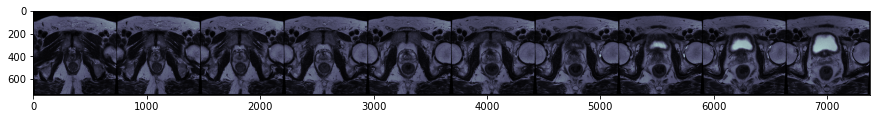

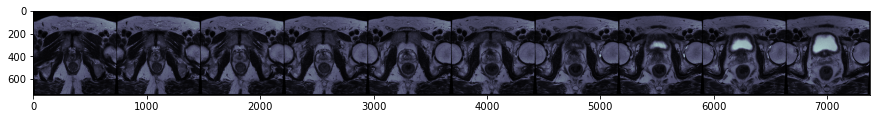

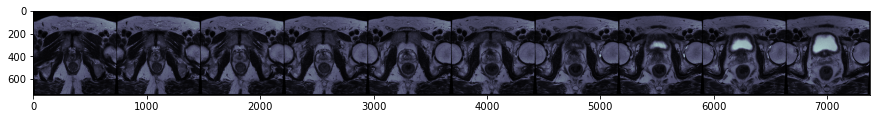

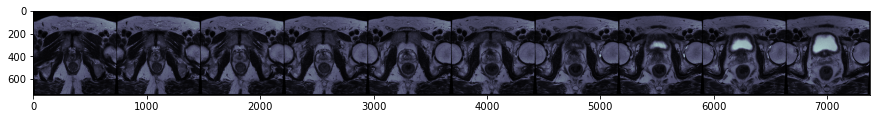

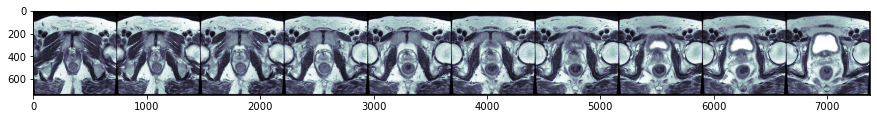

In [ ]:
im1.show()
im1.normalize('mean').show()
im1.normalize('median').show()
im1.normalize('max').show()
im1.hist_scaled().show()

### Comparison to SimpleITK Adaptive Histogram Equalization

`faimed3d` allows for simple intensity corrections through histogram equalization. These implemetations are not as good as the ones provided by SimpleITK but a lot faster. Still, for optimal results using SimpleITK version might be better. 

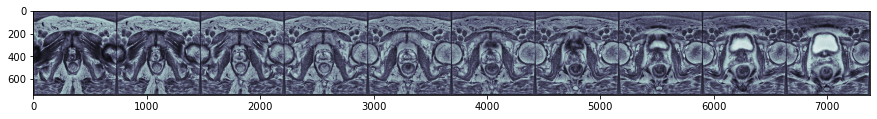

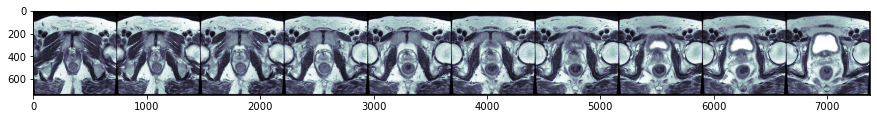

In [ ]:
image = sitk.Cast(im1.as_sitk(), sitk.sitkFloat32)
output = sitk.AdaptiveHistogramEqualization(image, radius=[20]*3, alpha=0.3, beta=0.3) # ~ 30-60 seconds
TensorDicom3D(sitk.GetArrayFromImage(output)).show() 
im1.hist_scaled().show()

### N4 Bias Field Correction
from official [SimpleITK docs](https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html)
> The N4 bias field correction algorithm is a popular method for correcting low frequency intensity non-uniformity present in MRI image data known as a bias or gain field. The method has also been successfully applied as flat-field correction in microscopy data. This method assumes a simple parametric model and does not require tissue classification.

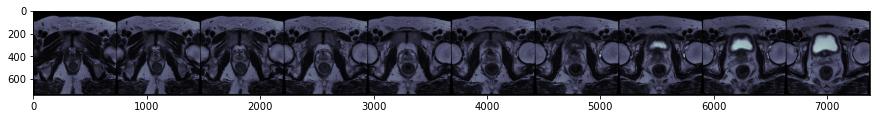

In [ ]:
corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrector.SetMaximumNumberOfIterations([3]*3)
output = corrector.Execute(sitk.Cast(im1.as_sitk(), sitk.sitkFloat32)) # needs float
TensorDicom3D(sitk.GetArrayFromImage(output)).show() #

`faimed3d` provides a wrapper class to apply both N4 Bias Field Correction and Adaptive Histogram Equalization, which basically just simplifies reading the data. 

In [ ]:
# export 
class ImageCorrectionWrapper(object):
    def __init__(self, 
                 n4_max_num_it = 3, 
                 hist_radius = [5,5,5], # radius in format [H x W x D]. Computation time scale ^3 with radius.   
                 hist_alpha  = 0.3, 
                 hist_beta = 0.3, 
                 do_n4 = True, 
                 do_hist = True, 
                 verbose = True):
        store_attr()
        if do_n4: 
            self.corrector = sitk.N4BiasFieldCorrectionImageFilter()

    def __call__(self, orig_file, fn_out=None):
        if isinstance(orig_file, str): 
            if fn_out is None:
                fn_out = self.strip_suffix(fn_in)+'corrected.nii.gz'
            self.convert_string(orig_file, fn_out)
        if isinstance(orig_file, TensorDicom3D):
            if fn_out is None:
                try: fn_out = self.strip_suffix(orig_file.fn)+'corrected.nii.gz'
                except: raise ValueError('Please set a name for the output')
            self._convert(orig_file.as_sitk(), fn_out)
        if self.verbose: 
            print('Coreccted and wrote file to {}'.format(fn_out))
        
    def convert_string(self, fn_in, fn_out):
        im = self.read_image(fn_in)
        self._convert(im, fn_out)

    def _convert(self, im, fn_out):
        if self.do_n4:
            im = self.n4_bias_correction(im)
        if self.do_hist:
            im = self.hist_equal(im)
        sitk.WriteImage(im, fn_out)
    
            
    def n4_bias_correction(self, im):
        self.corrector.SetMaximumNumberOfIterations([self.n4_max_num_it]*3)
        return self.corrector.Execute(im) 
    
    def hist_equal(self, im):
        return sitk.AdaptiveHistogramEqualization(sitk.Cast(im, sitk.sitkInt16), 
                                                  radius=self.hist_radius*3, 
                                                  alpha=self.hist_alpha, 
                                                  beta=self.hist_beta)
    
    def read_image(self, fn):
        "copy of TensorDicom3D.load"
        if isinstance(fn, str): fn = Path(fn)
        if fn.is_dir(): 
            SeriesReader = sitk.ImageSeriesReader()
            dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
            SeriesReader.SetFileNames(dicom_names)
            im = SeriesReader.Execute()
            return sitk.Cast(im, sitk.sitkFloat32)
        elif fn.is_file():
            return sitk.ReadImage(str(fn), outputPixelType=sitk.sitkFloat32)
        else:
            raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))     
            
        
    def strip_suffix(self, fn):
        fn = Path(fn)
        extensions = "".join(fn.suffixes)
        new_fn = str(fn).replace(extensions, '')
        return new_fn+'/' if fn.is_dir() else new_fn

## Piecewise Linear Histogram Matching [1,2]

[1] N. Laszlo G and J. K. Udupa, “On Standardizing the MR Image Intensity Scale,” Magn. Reson. Med., vol. 42, pp. 1072–1081, 1999.

[2] M. Shah, Y. Xiao, N. Subbanna, S. Francis, D. L. Arnold, D. L. Collins, and T. Arbel, “Evaluating intensity normalization on MRIs of human brain with multiple sclerosis,” Med. Image Anal., vol. 15, no. 2, pp. 267–282, 2011.

### implementation adapted from: https://github.com/jcreinhold/intensity-normalization, ported to pytorch (no use of numpy)
### uses https://github.com/aliutkus/torchinterp1d


## Usage:
First, find the standard scale for all inputs (find_standard_scale()).

Second, appy standard scale to all inputs (apply_nyul_udupa_normalization() for single input).

In [ ]:
import importlib.util
spec = importlib.util.spec_from_file_location("module.name", "/media/janis/Storage1/torchinterp1d/torchinterp1d/interp1d.py")
torchinterp1d = importlib.util.module_from_spec(spec)
spec.loader.exec_module(torchinterp1d)

In [ ]:
def find_standard_scale(inputs, i_min=1, i_max=99, i_s_min=1, i_s_max=100, l_percentile=10, u_percentile=90, step=10):
    """
    determine the standard scale for the set of images
    Args:
        inputs (list): set of TensorDicom3D objects which are to be normalized
        i_min (float): minimum percentile to consider in the images
        i_max (float): maximum percentile to consider in the images
        i_s_min (float): minimum percentile on the standard scale
        i_s_max (float): maximum percentile on the standard scale
        l_percentile (int): middle percentile lower bound (e.g., for deciles 10)
        u_percentile (int): middle percentile upper bound (e.g., for deciles 90)
        step (int): step for middle percentiles (e.g., for deciles 10)
    Returns:
        standard_scale (np.ndarray): average landmark intensity for images
        percs (np.ndarray): array of all percentiles used
    """
    
    percs = torch.cat([torch.tensor([i_min]), torch.arange(l_percentile, u_percentile+1, step), torch.tensor([i_max])], dim=0)
    standard_scale = torch.zeros(len(percs))
    
    for i, input_image in enumerate (inputs):
        mask_data = input_image > input_image.mean()
        masked = input_image[mask_data > 0]
        landmarks = get_landmarks(masked, percs)
        min_p = get_percentile(masked, i_min)
        max_p = get_percentile(masked, i_max)
        new_landmarks = torchinterp1d.Interp1d()(torch.FloatTensor([min_p, max_p]), torch.FloatTensor([i_s_min, i_s_max]), landmarks)
        standard_scale += new_landmarks[0]
    standard_scale = standard_scale / len(inputs)
    return standard_scale, percs

def get_percentile(t: torch.tensor, q: float) -> Union[int, float]:
    """
    Return the ``q``-th percentile of the flattened input tensor's data.
    
    CAUTION:
     * Needs PyTorch >= 1.1.0, as ``torch.kthvalue()`` is used.
     * Values are not interpolated, which corresponds to
       ``numpy.percentile(..., interpolation="nearest")``.
       
    :param t: Input tensor.
    :param q: Percentile to compute, which must be between 0 and 100 inclusive.
    :return: Resulting value (float).
    """
    
    # Note that ``kthvalue()`` works one-based, i.e. the first sorted value
    # indeed corresponds to k=1, not k=0! Use float(q) instead of q directly,
    # so that ``round()`` returns an integer, even if q is a np.float32.
    
    k = 1 + round(.01 * float(q) * (t.numel() - 1))
    result = t.view(-1).kthvalue(k)[0].item()
    
    return result

def get_landmarks(t: torch.tensor, percentiles: torch.tensor):
    """
    Returns the input's landmarks.
       
    :param t: Input tensor.
    :param percentiles: Percentiles to calculate landmarks for.
    :return: Resulting landmarks (torch.tensor).
    """
    landmarks = [];
    
    for i, perc in enumerate (percentiles):
        
        landmark = get_percentile(t, perc.item())
        landmarks.append(landmark)
        
    return torch.FloatTensor(landmarks)

def apply_nyul_udupa_normalization(input_image, landmark_percs, standard_scale):
    """
    do the Nyul and Udupa histogram normalization routine with a given set of learned landmarks
    Args:
        input_image (TensorDicom3D): image on which to find landmarks
        landmark_percs (torch.tensor): corresponding landmark points of standard scale
        standard_scale (torch.tensor): landmarks on the standard scale
    Returns:
        normalized (TensorDicom3D): normalized image
    """
    mask_data = input_image > input_image.mean()
    masked = input_image[mask_data > 0]
    landmarks = get_landmarks(masked, landmark_percs)
    
    # unfortunately torchinterp1d does only accept 2D inputs, so we have to iterrate over the
    # TensorDicom3D object to normalize every single slice accordingly and afterwards
    # reconstruct the 3D tensor image
    
    slices = []
    
    for i, input_slice in enumerate (input_image):
        normed_slice = torchinterp1d.Interp1d()(landmarks, standard_scale, input_slice)
        
        slices.append(normed_slice)
        
        normed_image = TensorDicom3D(torch.stack([*slices]))
    
    return normed_image

## Example Usage:

In [ ]:
im1 = TensorDicom3D.create("/media/scaleout/vahldiek/MRI/SIJ/TRAINING/01013/TIRM/", load_header=False)
im2 = TensorDicom3D.create("/media/scaleout/vahldiek/MRI/SIJ/TRAINING/01014/TIRM/", load_header=False)
im3 = TensorDicom3D.create("/media/scaleout/vahldiek/MRI/SIJ/TRAINING/01015/TIRM/", load_header=False)
im4 = TensorDicom3D.create("/media/scaleout/vahldiek/MRI/SIJ/TRAINING/01015/T1/", load_header=False)
inputs = [im1, im4, im3, im2];

In [ ]:
standard_scale, percs = find_standard_scale(inputs)
standard_scale, percs

In [ ]:
apply_nyul_udupa_normalization(im1, percs, standard_scale).show()

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 01_basics.ipynb.
Converted 01_normalization.ipynb.
Converted 02_transforms.ipynb.
Converted 03_datablock.ipynb.
Converted 04_datasets.ipynb.
Converted 05a_models.modules.ipynb.
Converted 05b_models.alexnet.ipynb.
Converted 05b_models.deeplabv3.ipynb.
Converted 05b_models.densenet.ipynb.
Converted 05b_models.resnet.ipynb.
Converted 05c_models.DynamicUnet.ipynb.
Converted 05c_models.siamese.ipynb.
Converted 05c_models.unet.ipynb.
Converted 05d_models.losses.ipynb.
Converted 06_callback.ipynb.
Converted 99_tools.ipynb.
Converted index.ipynb.
